In [1]:
#Amount google drive
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/case_study_opti/latent-communication'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['data', 'figures', 'improve_decouple.ipynb', 'lightning_logs', 'models', 'optimization', 'results', 'results_stitching.csv', 'stitching', 'utils']


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install lightning
!pip install omegaconf

In [4]:
from pathlib import Path
import os
# Change working directory
PROJECT_ROOT_DIR = "latent-communication"
current_dir = os.getcwd()
# Find the project root by walking up the directory tree
while current_dir:
    if os.path.basename(current_dir) == PROJECT_ROOT_DIR:
        break  # Found the project root!
    current_dir = os.path.dirname(current_dir)
else:
    raise FileNotFoundError(f"Project root '{PROJECT_ROOT_DIR}' not found in the directory tree.")
os.chdir(current_dir)

import torch
import numpy as np
from tqdm import tqdm
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import pandas as pd

from utils.dataloaders.get_dataloaders import define_dataloader
from utils.sampler import *
from optimization.fit_mapping import create_mapping
from utils.model import load_model, get_transformations
from utils.get_mapping import load_mapping


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)

# Function to reverse the ToTensor transformation
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = tensor.mul(255).byte()  # Scale the pixel values back to [0, 255]
    array = tensor.numpy()  # Convert to numpy array
    array = array.reshape(28, 28)  # Reshape to 28x28
    return array

# Display the images
def show_images(images, titles,suptitle=""):
    fig, axs = plt.subplots(len(images), 3, figsize=(15, 5*len(images)))
    plt.suptitle(suptitle)
    for i, (original, stitched, model2) in enumerate(images):
        axs[i, 0].imshow(tensor_to_image(original), cmap='gray')
        axs[i, 0].set_title(f'{titles[i]} - Original')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(tensor_to_image(stitched), cmap='gray')
        axs[i, 1].set_title(f'{titles[i]} - Stitched')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(tensor_to_image(model2), cmap='gray')
        axs[i, 2].set_title(f'{titles[i]} - Model 2')
        axs[i, 2].axis('off')
    plt.savefig(f"results/figures/{suptitle}")
    plt.show()

In [5]:
# Function to clear GPU memory
def clear_memory():
    torch.cuda.empty_cache()

def calculate_and_save_mapping(model1, model2, sampling_strategy, sampled_images, parameters, file1, file2, transformations_database, num_samples, lamda, DEVICE,epochs,lr):

    name_dataset1, name_model1, size_of_the_latent1, seed1 = file1.strip(".pth").split("_")
    name_dataset2, name_model2, size_of_the_latent2, seed2 = file2.strip(".pth").split("_")

    # Set the model to evaluation and sends them to the DEVICE
    model1.to(torch.float32).to(DEVICE).eval()
    model2.to(torch.float32).to(DEVICE).eval()
    # Get latent of the sampled images
    latent_left_sampled_equally = model1.get_latent_space(sampled_images)
    latent_right_sampled_equally = model2.get_latent_space(sampled_images)
    latent_left_sampled_equally = latent_left_sampled_equally.to(torch.float32).cpu().detach().numpy()
    latent_right_sampled_equally = latent_right_sampled_equally.to(torch.float32).cpu().detach().numpy()
    # Create mapping and visualize
    cfg = Config(**parameters)
    mapping = create_mapping(cfg, latent_left_sampled_equally, latent_right_sampled_equally, do_print=False,epochs=epochs,lr=lr)
    mapping.fit()
    #Plot loss
    loss_history = mapping.mapping.loss_history
    plt.plot(loss_history)
    storage_path = f'results/transformations/mapping_files/{name_model2}/'
    Path(storage_path).mkdir(parents=True, exist_ok=True)
    filename = f"{file1.strip('.pth')}>{file2.strip('.pth')}>{cfg.mapping}_{num_samples}_{lamda}_{sampling_strategy}"
    mapping.save_results(storage_path +  filename)
    transformations_database = pd.concat([transformations_database, pd.DataFrame({"model1": [file1], "model2": [file2], "mapping": [storage_path]})], ignore_index=True)
    return transformations_database

In [6]:
folder1 = "models/checkpoints/PCKTAE/FMNIST"
folder2 = "models/checkpoints/PCKTAE/FMNIST"
file1 = "FMNIST_PCKTAE_100_3.pth"
file2 = "FMNIST_PCKTAE_100_1.pth"
num_samples = 500
mapping_type = "Decouple"
lamda = 0.25
sampling_strategy = 'equally'
#Get data
df_save_mappings = pd.DataFrame(columns=["model1", "model2", "mapping"])
images, labels, n_classes = define_dataloader(file1, file2, False)
images = images.type(torch.float32).to(DEVICE)
labels = labels.type(torch.float32).to(DEVICE)
# Get model info and define parameters
parameters = {"num_samples": num_samples, "mapping": mapping_type, "lamda": lamda} #This is done to go around some hydra stuff (<3 kai)
name_dataset1, name_model1, size_of_the_latent1, seed1 = file1.strip(".pth").split("_")
name_dataset2, name_model2, size_of_the_latent2, seed2 = file2.strip(".pth").split("_")
#Load models
model_folder = os.listdir(f'results/transformations/mapping_files/{name_model2}')
model1 = load_model(model_name=name_model1, name_dataset=name_dataset1, latent_size=int(size_of_the_latent1), seed=int(seed1), model_path = folder1 + '/' + file1)
model2 = load_model(model_name=name_model2, name_dataset=name_dataset2, latent_size=int(size_of_the_latent2), seed=int(seed2), model_path = folder1 + '/' + file2)

/content/gdrive/MyDrive/case_study_opti/latent-communication/utils/dataloaders/full_dataloaders.py:117: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(train_data), torch.tensor(train_labels)


In [7]:
#Sample images
images_sampled, labels_sampled = sample_equally_per_class_images(num_samples, images, labels)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 20.0 K | n/a 
---------------------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 20.0 K | n/a 
---------------------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estim

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=500` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


Model saved at  results/transformations/mapping_files/PCKTAE/FMNIST_PCKTAE_100_3>FMNIST_PCKTAE_100_1>Decouple_500_0.25_equally


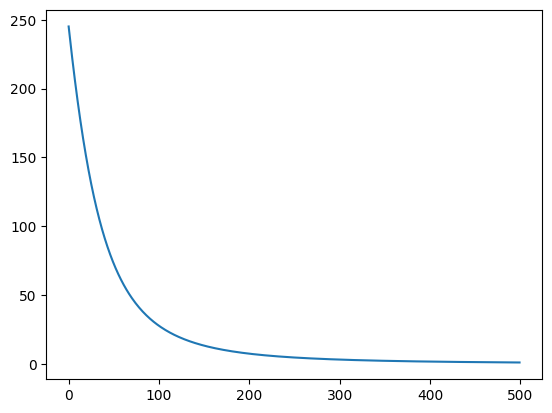

In [11]:
epochs = 500
lr = 0.01
df_save_mappings = calculate_and_save_mapping(model1, model2, sampling_strategy, images_sampled, parameters, file1, file2, df_save_mappings, num_samples, lamda, DEVICE,epochs,lr)

2732
5994
31626


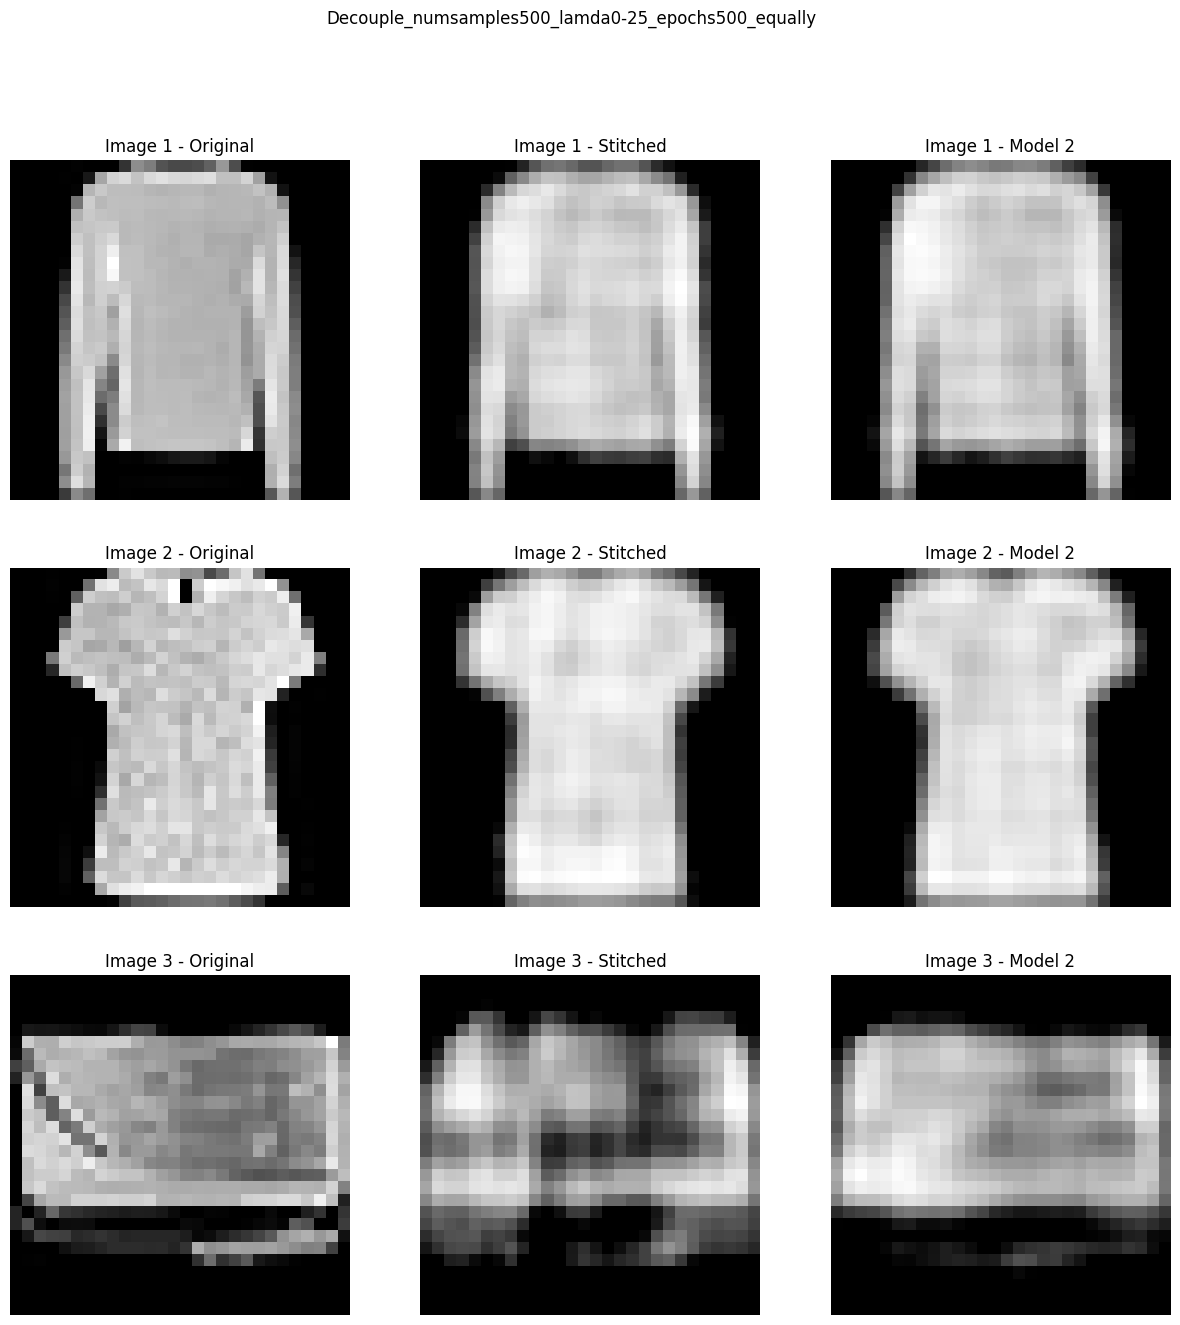

In [12]:
model1 = model1.eval()
model2 = model2.eval()
suptitle = f"{mapping_type}_numsamples{num_samples}_lamda{str(lamda).replace('.','-')}_epochs{epochs}_{sampling_strategy}"

mapping_path = "results/transformations/mapping_files/PCKTAE/"
mapping_name = f"{file1.strip('.pth')}>{file2.strip('.pth')}>{mapping_type}_{num_samples}_{lamda}_{sampling_strategy}"
mapping = load_mapping(mapping_path + mapping_name, mapping_type)


# List to store images and titles
images_list = []
titles_list = []

# Loop to process 5 random images
for i in range(3):
    np.random.seed(i*3)
    index = np.random.randint(0, len(images))
    print(index)
    image = images[index].unsqueeze(0)

    latent_1 = model1.get_latent_space(image)
    latent_1 = mapping.transform(latent_1)

    image_stiched = model2.decode(latent_1.float())
    image_model2 = model2(image)

    images_list.append((image.squeeze(), image_stiched.squeeze(), image_model2.squeeze()))
    titles_list.append(f'Image {i+1}')

# Display the images
show_images(images_list, titles_list,suptitle)

# Try new approach:
## Learn A1, learn A2
## Fix A2 and then optimise A1 with A2 fixed

In [ ]:
folder1 = "models/checkpoints/PCKTAE/FMNIST"
folder2 = "models/checkpoints/PCKTAE/FMNIST"
file1 = "FMNIST_PCKTAE_100_3.pth"
file2 = "FMNIST_PCKTAE_100_1.pth"
num_samples = 50
mapping_type = "Decouple"
lamda = 0.0
sampling_strategy = 'equally'
#Get data
df_save_mappings = pd.DataFrame(columns=["model1", "model2", "mapping"])
images, labels, n_classes = define_dataloader(file1, file2, False)
images = images.type(torch.float32).to(DEVICE)
labels = labels.type(torch.float32).to(DEVICE)
# Get model info and define parameters
parameters = {"num_samples": num_samples, "mapping": mapping_type, "lamda": lamda} #This is done to go around some hydra stuff (<3 kai)
name_dataset1, name_model1, size_of_the_latent1, seed1 = file1.strip(".pth").split("_")
name_dataset2, name_model2, size_of_the_latent2, seed2 = file2.strip(".pth").split("_")
#Load models
model_folder = os.listdir(f'results/transformations/mapping_files/{name_model2}')
model1 = load_model(model_name=name_model1, name_dataset=name_dataset1, latent_size=int(size_of_the_latent1), seed=int(seed1), model_path = folder1 + '/' + file1)
model2 = load_model(model_name=name_model2, name_dataset=name_dataset2, latent_size=int(size_of_the_latent2), seed=int(seed2), model_path = folder1 + '/' + file2)

In [ ]:
images_sampled, labels_sampled = sample_equally_per_class_images(num_samples, images, labels)

In [ ]:
parameters

{'num_samples': 50, 'mapping': 'Decouple', 'lamda': 0.0}

In [ ]:
Config(**{'num_samples': num_samples, 'mapping': 'Linear', 'lamda': 0.0})

In [ ]:
model1.to(torch.float32).to(DEVICE).eval()
model2.to(torch.float32).to(DEVICE).eval()
# Get latent of the sampled images
latent_left_sampled_equally = model1.get_latent_space(images_sampled)
latent_right_sampled_equally = model2.get_latent_space(images_sampled)
latent_left_sampled_equally = latent_left_sampled_equally.to(torch.float32).cpu().detach().numpy()
latent_right_sampled_equally = latent_right_sampled_equally.to(torch.float32).cpu().detach().numpy()
# Create mapping and visualize
cfg= Config(**{'num_samples': num_samples, 'mapping': 'DecoupleAlternate', 'lamda': 0.0})
cfg_linear = Config(**{'num_samples': num_samples, 'mapping': 'Linear', 'lamda': 0.0})
#Get A1
mapping_A1 = create_mapping(cfg_linear, latent_left_sampled_equally, latent_right_sampled_equally, do_print=True)
mapping_A1.fit()
A1 = mapping_A1.A.value
#Get A2
mapping_A2 = create_mapping(cfg_linear,latent_right_sampled_equally, latent_left_sampled_equally,do_print=True)
mapping_A2.fit()
A2 = mapping_A2.A.value
#Alternate Opti
mapping_A1_decouple = create_mapping(cfg, latent_left_sampled_equally, latent_right_sampled_equally,A2, do_print=True)
mapping_A1_decouple.fit(initial_guess=A1)
#Save result
storage_path = f'results/transformations/mapping_files/{name_model2}/'
Path(storage_path).mkdir(parents=True, exist_ok=True)
filename = f"{file1.strip('.pth')}>{file2.strip('.pth')}>{cfg.mapping}_{num_samples}_{lamda}_{sampling_strategy}"
mapping.save_results(storage_path +  filename)

Failure:interrupted


SolverError: Solver 'SCS' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
model1 = model1.eval()
model2 = model2.eval()

mapping_path = "results/transformations/mapping_files/PCKTAE/"
mapping_name = f"{file1.strip('.pth')}>{file2.strip('.pth')}>{mapping_type}_{num_samples}_{lamda}_{sampling_strategy}"
mapping = load_mapping(mapping_path + mapping_name, mapping_type)


# List to store images and titles
images_list = []
titles_list = []

# Loop to process 5 random images
for i in range(5):
    index = np.random.randint(0, len(images))
    image = images[index].unsqueeze(0)

    latent_1 = model1.get_latent_space(image)
    latent_1 = mapping.transform(latent_1)

    image_stiched = model2.decode(latent_1.float())
    image_model2 = model2(image)

    images_list.append((image.squeeze(), image_stiched.squeeze(), image_model2.squeeze()))
    titles_list.append(f'Image {i+1}')

# Display the images
show_images(images_list, titles_list)